In [1]:
!pip install transformers --quiet

import pandas as pd
import torch
from transformers import pipeline


In [3]:
import csv

with open('/content/data.csv', encoding='utf-8', errors='ignore') as f:
    for i, row in enumerate(f):
        if '"' in row and row.count('"') % 2 != 0:
            print(f"Possible unclosed quote at row {i+1}")



Possible unclosed quote at row 21051
Possible unclosed quote at row 21065
Possible unclosed quote at row 21609
Possible unclosed quote at row 21623
Possible unclosed quote at row 23959
Possible unclosed quote at row 23973
Possible unclosed quote at row 27774


In [4]:
MODEL = "jy46604790/Fake-News-Bert-Detect"

clf = pipeline(
    "text-classification",
    model=MODEL,
    tokenizer=MODEL,
    truncation=True,
    padding=True,
    max_length=512,
    top_k=1,
    return_all_scores=False,
    device=0 if torch.cuda.is_available() else -1
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


In [7]:
df = pd.read_csv('/content/data.csv')  # or whatever your cleaned file is

# Combine title + text for BERT input
df['text_combined'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
texts = df['text_combined'].tolist()


In [8]:
batch_size = 64
predictions = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    try:
        batch_preds = clf(batch)
        predictions.extend(batch_preds)
    except Exception as e:
        print(f"Batch {i}-{i+batch_size} failed:", e)
        predictions.extend([None] * len(batch))


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [9]:
def extract_label(pred):
    if isinstance(pred, list) and len(pred) > 0 and 'label' in pred[0]:
        return pred[0]['label']
    elif isinstance(pred, dict) and 'label' in pred:
        return pred['label']
    return None

df['bert_prediction'] = [extract_label(p) for p in predictions]
df['predicted_label'] = df['bert_prediction'].map({'FAKE': 0, 'REAL': 1})

print(df['predicted_label'].value_counts())


Series([], Name: count, dtype: int64)


In [10]:
print(predictions[:5])
print(len(predictions))


[[{'label': 'LABEL_1', 'score': 0.9999125003814697}], [{'label': 'LABEL_1', 'score': 0.9999138116836548}], [{'label': 'LABEL_1', 'score': 0.9999122619628906}], [{'label': 'LABEL_1', 'score': 0.9999138116836548}], [{'label': 'LABEL_1', 'score': 0.9999135732650757}]]
39942


In [11]:
print(df['bert_prediction'].value_counts(dropna=False))


bert_prediction
LABEL_1    20007
LABEL_0    19935
Name: count, dtype: int64


In [12]:
# Map model output to your binary labels
df['predicted_label'] = df['bert_prediction'].map({'LABEL_0': 0, 'LABEL_1': 1})

# Check result
print(df['predicted_label'].value_counts())


predicted_label
1    20007
0    19935
Name: count, dtype: int64


In [13]:
from sklearn.metrics import accuracy_score, classification_report

df_clean = df.dropna(subset=['predicted_label'])
print("✅ Accuracy:", accuracy_score(df_clean['label'], df_clean['predicted_label']))
print(classification_report(df_clean['label'], df_clean['predicted_label']))


✅ Accuracy: 0.9993991287366681
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19943
           1       1.00      1.00      1.00     19999

    accuracy                           1.00     39942
   macro avg       1.00      1.00      1.00     39942
weighted avg       1.00      1.00      1.00     39942



In [15]:
df[['title', 'text', 'subject', 'date', 'predicted_label']].rename(
    columns={'predicted_label': 'label'}
).to_csv("bert_predictions.csv", index=False)



In [16]:
from google.colab import files
files.download("bert_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#VALIDATION DATA

In [19]:
import pandas as pd

val_df = pd.read_csv('/content/validation_data.csv')
val_df['text_combined'] = val_df['title'].fillna('') + ' ' + val_df['text'].fillna('')
val_texts = val_df['text_combined'].tolist()


In [20]:
batch_size = 64  # adjust if you get memory errors
val_predictions = []

for i in range(0, len(val_texts), batch_size):
    batch = val_texts[i:i + batch_size]
    try:
        batch_preds = clf(batch)
        val_predictions.extend(batch_preds)
    except Exception as e:
        print(f"Batch {i}-{i+batch_size} failed:", e)
        val_predictions.extend([None] * len(batch))


In [21]:
def extract_label(pred):
    if isinstance(pred, list) and len(pred) > 0 and 'label' in pred[0]:
        return pred[0]['label']
    elif isinstance(pred, dict) and 'label' in pred:
        return pred['label']
    return None

val_df['bert_prediction'] = [extract_label(p) for p in val_predictions]
val_df['label'] = val_df['bert_prediction'].map({'LABEL_0': 0, 'LABEL_1': 1})


In [22]:
val_df[['title', 'text', 'subject', 'date', 'label']].to_csv('bert_validation_predictions.csv', index=False)


In [23]:
from google.colab import files
files.download('bert_validation_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

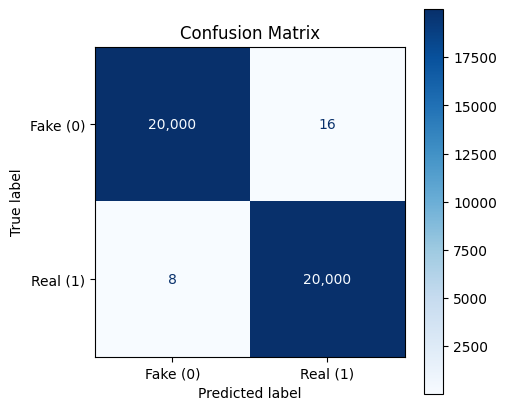

In [25]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
# Force integer labels
for text in ax.texts:
    text.set_text(f"{int(float(text.get_text())):,}")
plt.show()


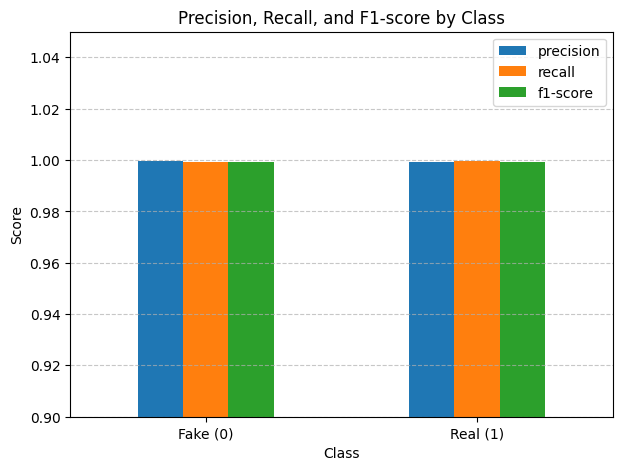

In [26]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the report as a dictionary
report = classification_report(
    df_clean['label'],
    df_clean['predicted_label'],
    output_dict=True,
    target_names=['Fake (0)', 'Real (1)']
)
# Convert to DataFrame for plotting
report_df = pd.DataFrame(report).T.loc[['Fake (0)', 'Real (1)'], ['precision', 'recall', 'f1-score']]

report_df.plot.bar(figsize=(7, 5))
plt.title("Precision, Recall, and F1-score by Class")
plt.ylim(0.9, 1.05)  # Adjust this if your scores are lower
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
